In [7]:
!pip install keras-preprocessing

In [8]:
import pandas as pd
import tensorflow
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
from keras.models import load_model
import cv2


In [4]:

# Mount Google Drive
drive.mount("/content/drive")

# === Data Preprocessing: Handling Two Image Folders ===
# Read the metadata CSV file
data = pd.read_csv("/content/drive/MyDrive/archive (7)/HAM10000_metadata.csv")

# Get a list of image files from both folders
image_files_part1 = os.listdir("/content/drive/MyDrive/archive (7)/HAM10000_images_part_1/")
image_files_part2 = os.listdir("/content/drive/MyDrive/archive (7)/HAM10000_images_part_2/")

# Create a dictionary to map image_id to its full path
image_paths = {}
for filename in image_files_part1:
    image_paths[filename.replace('.jpg', '')] = os.path.join("/content/drive/MyDrive/archive (7)/HAM10000_images_part_1/", filename)
for filename in image_files_part2:
    image_paths[filename.replace('.jpg', '')] = os.path.join("/content/drive/MyDrive/archive (7)/HAM10000_images_part_2/", filename)

# Add the 'full_path' column to the DataFrame by mapping image_id
data['full_path'] = data['image_id'].map(image_paths.get)

# Drop any rows where an image file was not found
data = data.dropna(subset=['full_path'])

# Separate features (X) and target (Y)
X = data[['full_path', 'dx', 'lesion_id']]
Y = X.pop('dx').to_frame()

# Split the data into training, validation, and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.17, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.17, random_state=42)

# Combine features and labels for each dataset
train = pd.concat([X_train, Y_train], axis=1)
val = pd.concat([X_val, Y_val], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

# Label Encoding
encoder = LabelEncoder()
encoder.fit(train['dx'])
train['label'] = encoder.transform(train['dx'])
val['label'] = encoder.transform(val['dx'])
test['label'] = encoder.transform(test['dx'])

# === Image Data Generators ===
# Training data generator with augmentation
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, width_shift_range=0.0, height_shift_range=0.0)

# Validation and test data generator (only rescaling)
val_test_generator = ImageDataGenerator(rescale=1./255)

# Use flow_from_dataframe with the full path. The 'directory' argument is set to None.
train_data = train_generator.flow_from_dataframe(dataframe=train,
                                                 x_col="full_path",
                                                 y_col="dx",
                                                 batch_size=32,
                                                 directory=None,
                                                 shuffle=True,
                                                 class_mode="categorical",
                                                 target_size=(224, 224))

val_data = val_test_generator.flow_from_dataframe(dataframe=val,
                                                  x_col="full_path",
                                                  y_col="dx",
                                                  batch_size=64,
                                                  directory=None,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(224, 224))

test_data = val_test_generator.flow_from_dataframe(dataframe=test,
                                                   x_col="full_path",
                                                   y_col="dx",
                                                   batch_size=1,
                                                   directory=None,
                                                   shuffle=False,
                                                   class_mode="categorical",
                                                   target_size=(224, 224))

# === Model Definition ===
# Pre-trained MobileNetV2 base model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Define the neural network model
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax')) # Switched to softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Callbacks and Training ===
learning_control = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=.5, min_lr=0.0001)

history = model.fit(x=train_data,
                    steps_per_epoch=train_data.samples // train_data.batch_size,
                    validation_data=val_data,
                    validation_steps=val_data.samples // val_data.batch_size,
                    verbose=1,
                    epochs=15,
                    callbacks=[learning_control])

# === Model Evaluation and Prediction ===
# Get predicted class indices
test_data.reset()
predictions = model.predict(test_data, steps=len(test_data), verbose=1)
y_pred = np.argmax(predictions, axis=1)


# Save the model
model.save('final_model.h5')


# === Plotting the results ===
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print Final Accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Validation Accuracy: {final_val_acc:.2f}")
# === Prediction Function ===
# Define a mapping from class indices to class names
class_names = list(train_data.class_indices.keys())





Mounted at /content/drive
Found 6898 validated image filenames belonging to 7 classes.
Found 1414 validated image filenames belonging to 7 classes.
Found 1703 validated image filenames belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2281s 9s/step - accuracy: 0.6307 - loss: 1.3542 - val_accuracy: 0.6733 - val_loss: 1.6466 - learning_rate: 0.0010
Epoch 2/15
  1/215 ━━━━━━━━━━━━━━━━━━━━ 26:57 8s/step - accuracy: 0.7812 - loss: 0.9330

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


215/215 ━━━━━━━━━━━━━━━━━━━━ 89s 381ms/step - accuracy: 0.7812 - loss: 0.9330 - val_accuracy: 0.6733 - val_loss: 1.2697 - learning_rate: 0.0010
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1891s 9s/step - accuracy: 0.6806 - loss: 0.9171 - val_accuracy: 0.6733 - val_loss: 1.7109 - learning_rate: 0.0010
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 87s 374ms/step - accuracy: 0.6250 - loss: 1.3613 - val_accuracy: 0.6733 - val_loss: 1.7104 - learning_rate: 0.0010
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7232 - loss: 0.7900
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 ━━━━━━━━━━━━━━━━━━━━ 1885s 9s/step - accuracy: 0.7232 - loss: 0.7900 - val_accuracy: 0.6271 - val_loss: 1.6604 - learning_rate: 0.0010
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 142s 631ms/step - accuracy: 0.7188 - loss: 0.7014 - val_accuracy: 0.6222 - val_loss: 1.6599 - learning_rate: 5.0000e-04
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1940s 9s/step - accuracy: 0.7552 - loss: 0.

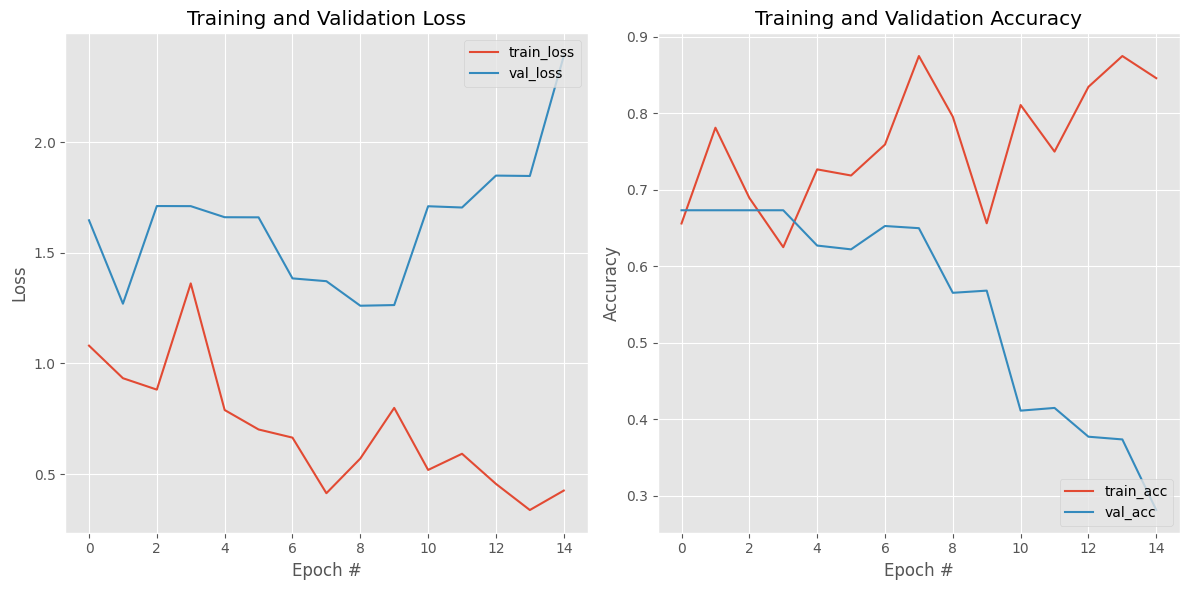

Final Training Accuracy: 0.85
Final Validation Accuracy: 0.28


In [9]:
# === Plotting the results ===
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print Final Accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Validation Accuracy: {final_val_acc:.2f}")
# === Prediction Function ===
# Define a mapping from class indices to class names
class_names = list(train_data.class_indices.keys())


In [15]:
import cv2
import numpy as np
from keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/Assignment/final_model.h5')

# Define a mapping from class indices to class names
# Example class names (modify according to your model's training)
class_names = ['Class VASC', 'Class MEL', 'Class BKL', 'Class BCC', 'Class AKIEC', 'Class NV', 'Class DF']

# Define a function to preprocess the image
def preprocess_image(image):
    # Resize the image to match the input size expected by the model (224x224 for MobileNetV2)
    resized_image = cv2.resize(image, (224, 224))
    # Normalize the pixel values to [0, 1] (common for deep learning models)
    normalized_image = resized_image / 255.0
    return normalized_image

# Define a function to make predictions using an image path
def predict_image(image_path, model):
    # Load the image from the path
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Preprocess the image (resize, normalize, etc.)
    processed_image = preprocess_image(image)

    # Expand dimensions to match the model's expected input shape
    processed_image = np.expand_dims(processed_image, axis=0)

    # Make predictions
    predictions = model.predict(processed_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the corresponding class name using the class mapping
    predicted_class_name = class_names[predicted_class_index]

    # Return the predicted class name and probabilities
    return predicted_class_name, predictions

# Example usage
image_path = '/content/drive/MyDrive/archive (7)/HAM10000_images_part_1/ISIC_0028393.jpg'

try:
    predicted_class_name, predictions = predict_image(image_path, model)
    print("Predicted class:", predicted_class_name)  # Display the predicted class name
    print("Predictions:", predictions)  # Display raw probabilities for each class
except FileNotFoundError as e:
    print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Class NV
Predictions: [[0.0174703  0.08748666 0.06879943 0.04064363 0.03515071 0.48714525
  0.26330402]]
